In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Mounted at /content/gdrive


In [ ]:
#imports
print("Starting imports")
#basics
import time
print("Starting timer.")
startTime = time.time()

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("Imports Complete")

Starting imports
Starting timer.
Imports Complete


## Get Data

In [ ]:
#paths
mainPath = '/content/drive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Lu_Folder/Data_derivedVelocity/Data_derivedVelocity/'
data_full_ = mainPath + 'data_full_vMag.csv'
data_1201_ = mainPath + 'd1201_vMag.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read data in
print("Reading Data In_")
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)
print("Data read in completed.")

Reading Data In_
Data read in completed.


## RMSE Function


In [ ]:
print("Establishing RMSPE functions.")

Establishing RMSPE functions.


In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [ ]:
print("Function established.")

Function established.


## Clean Data/Prepare Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("Begin data cleaning.")

df1201 = df1201.drop(columns=['Unnamed: 0.1'])
df_all = df_all.drop(columns=['Unnamed: 0.1'])

# 1201 drop location variables
df1201_feats = df1201.drop(columns=['surf_x', 'surf_y'])

# df_all drop location variables
df_all_feats_target = df_all.drop(columns=['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

# 1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']]

# set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB', 'v_mag']

# split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

#FIX
num_missing_cols = X_given.shape[1] - df1201_feats_ordered.shape[1]
if num_missing_cols > 0:
    missing_cols = np.zeros((df1201_feats_ordered.shape[0], num_missing_cols))
    df1201_feats_ordered = np.concatenate((df1201_feats_ordered, missing_cols), axis=1)

# Combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))

# make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

print("Data cleaned.\nScaling beginning.")

# standardize
# Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

# can alternatively use the MinMaxScaler
print("Scaling Complete.\nSplitting Data Beginning.")

# split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706, :]
X_1201_data = X_all_std[632706:, :]

# # generate a randomseed for training and testing split
# generated = np.random.randint(0, 1000, 1)[0]
# print(f"Generated random split for train-test: {generated}")
generated = 168

# set the train-test split
# 60-40 showed the most promising from previous research and additional testing
train_size_ = 0.6
# split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(
    X_non1201, Y_all_std, train_size=train_size_, test_size=1 - train_size_, random_state=generated
)

# get validation data
val_split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=1 - val_split, test_size=val_split, random_state=generated
)

print(f"Data train-split complete with: {train_size_ * 100}% training, {(1- train_size_) * 100}% testing, {val_split*100}% validation")


Begin data cleaning.
Data cleaned.
Scaling beginning.
Scaling Complete.
Splitting Data Beginning.
Data train-split complete with: 60.0% training, 40.0% testing, 20.0% validation




```
# This is formatted as code
```

## Dense model

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD
import numpy as np

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(x_train.shape[-1],)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y=y_train, epochs=200, batch_size=5000, verbose=1, validation_split =0.3, shuffle=True
          )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                5

In [ ]:
y_pred_train = model.predict(x_train)

9491/9491 [==============================] - 17s 2ms/step


In [ ]:
y_pred_train.shape, y_train.shape

((303698, 1), (303698, 1))

In [ ]:
train_Predict_full_range = scaler_Y.inverse_transform(y_pred_train)
data_train_Y_full_range = scaler_Y.inverse_transform(y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

print('RMSE:',np.sqrt(mean_squared_error(data_train_Y_full_range, train_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_train_Y_full_range, train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_train_Y_full_range, train_Predict_full_range))
print('R^2 Score:', r2_score(data_train_Y_full_range, train_Predict_full_range))

RMSE: 126.97954193754585
RMSE Percentage: 22139.538594382266
RMSE Percentage-1: nan
Mean Absolute Error: 90.0449367225648
Mean Absolute Percentage Error: 2.417522885269361
R^2 Score: 0.5022131276188044


<ipython-input-8-aa62cd6b9d47>:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100


Prediction of track bed on test data

In [ ]:
y_predict_test = model.predict(x_test)

7909/7909 [==============================] - 11s 1ms/step


In [ ]:
y_test.shape, y_predict_test.shape

((253083, 1), (253083, 1))

In [ ]:
test_Predict_full_range = scaler_Y.inverse_transform(y_predict_test)
data_test_Y_full_range = scaler_Y.inverse_transform(y_test)

#Model Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

print('RMSE:',np.sqrt(mean_squared_error(data_test_Y_full_range, test_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_test_Y_full_range, test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_test_Y_full_range, test_Predict_full_range))
print('R^2 Score:', r2_score(data_test_Y_full_range, test_Predict_full_range))

RMSE: 126.98443788776973
RMSE Percentage: 14534.72813058484
RMSE Percentage-1: 920.9862024328484
Mean Absolute Error: 90.08476368563251
Mean Absolute Percentage Error: 2.2262572289839406
R^2 Score: 0.5027708123477563


##  Visualiztion Code


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np

In [ ]:
y_pred_1201 = model.predict(X_1201_data)
pred1201_normScale = scaler_Y.inverse_transform(y_pred_1201.reshape(-1,1))

45076/45076 [==============================] - 82s 2ms/step


In [ ]:
y_Predict_1201_full_flatten=pred1201_normScale.flatten()
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)

In [ ]:
d1201Comparison = pd.DataFrame(prediction_on_1201_2D)

#transpose the datasets to face the correct NSEW directions.
data_set1 = np.transpose(d1201Comparison)
data_set1 = np.flipud(data_set1)

In [ ]:
Dense = "X"
K_Nearest_Neighbor = "Y"

<ipython-input-33-6113f0f5b93e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels


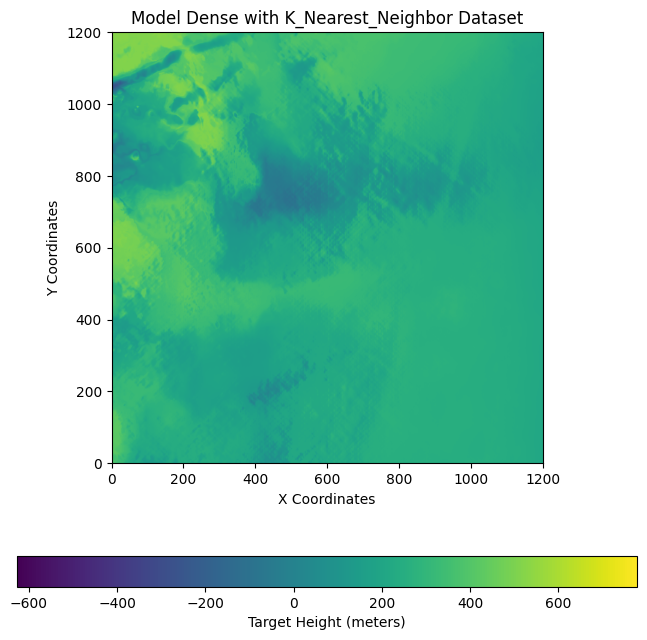

In [ ]:
figRunName = f"Model {'Dense'} with {'K_Nearest_Neighbor'} Dataset"
min_value = -626.96027
max_value = 778.96765

  # Create a figure and subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

  # Assuming data_set1 is defined and contains your data
  # Plot the first data set with shared color scale
im1 = axs.imshow(data_set1, vmin=min_value, vmax=max_value)
axs.set_title(f'{figRunName}')
axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels
axs.set_xlabel("X Coordinates")
axs.set_ylabel("Y Coordinates")

  # Define the colormap
colors = [
      (0.0, 0.0, 0.0),    # Black
      (0.0, 0.0, 0.3),    # Darker blue
      (0.0, 0.0, 0.5),    # Dark blue
      (0.0, 0.0, 0.7),    # Blue
      (0.0, 0.0, 1.0),    # Blue
      (0.0, 0.4, 0.8),    # Lighter blue
      (0.0, 0.6, 0.2),    # Dark green
      (0.0, 0.7, 0.3),    # Green
      (0.2, 0.8, 0.4),    # Light green
      (1.0, 0.8, 0.0),    # Orange
      (1.0, 0.0, 0.0),    # Red
  ]
mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

  # Add colorbar to the plot
fig.colorbar(im1, label="Target Height (meters)", ax=axs, location='bottom')

plt.show()
plt.close()

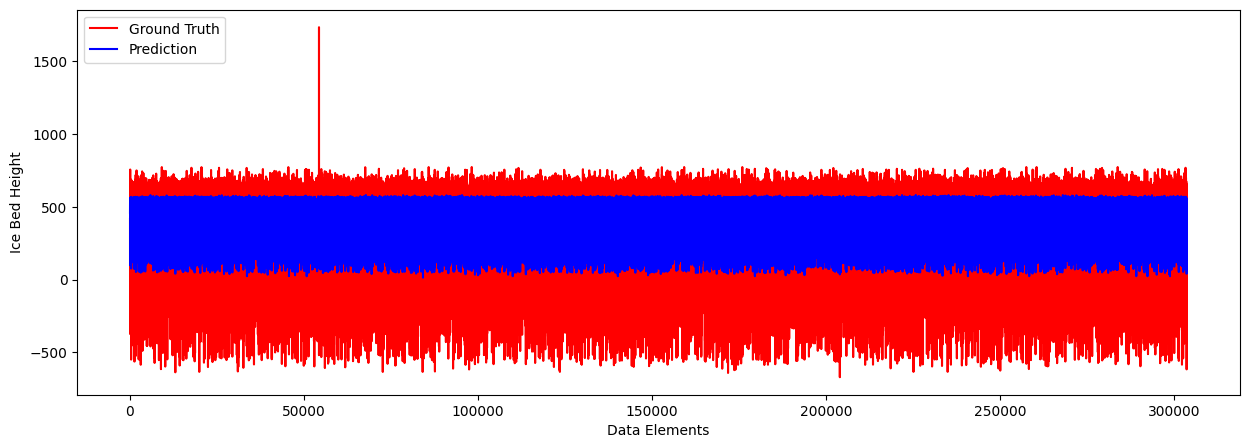

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

In [ ]:
endTime = time.time()
print(f"Total Time Taken: {endTime - startTime:.03f}ms")
print("Modeling COMPLETE")

Total Time Taken: 714.742ms
Modeling COMPLETE
